### Convolutional Neural Network 

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
plt.style.use('seaborn-white')
import warnings 
warnings.filterwarnings('ignore','DeprecatedWarnings')

In [2]:
torch.__version__

'1.7.1'

### Loading Datasets 

In [3]:
# MNIST Is considered to be the Hello World of CNN's and Deep Learning in General, so it is 
# generally provided from as the inbuild go-to project for beginners 
transforms = transforms.ToTensor()
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transforms)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transforms)

In [4]:
train_data 

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data 

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Data Loader Object

In [6]:
# Pytorch's convention to create dataloader objects, to be used in the models train cycle 
batch_s = 10
train_loader = DataLoader(train_data,batch_size=batch_s,shuffle=True)
test_loader = DataLoader(test_data,batch_size=batch_s,shuffle=False) 

### What is the Data about? 

In [7]:
# pipeline obj=1/
desc = '''
The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.
'''
print(desc)


The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.



In [8]:
(x_train, y_train) = train_data[0] # one sample

In [9]:
y_train # label

5

Text(0.5, 1.0, 'label 5')

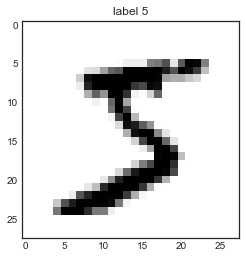

In [10]:
plt.imshow(x_train[0],cmap='binary')
plt.title('label {}'.format(y_train))

### Convolutional Neural Network Class

### Buidling Model 

In [11]:
class convolutional(nn.Module):
    
    def __init__(self,in_channel=1,output=10): 
        super().__init__() # inheriting nn.Module
        # defining Layer Functions 
        # input dimension = (b,28,28,1)
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=6, kernel_size=(3,3), stride=1 )
        # (b,26,26,6)
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)) # f=2, s=2 
        #  dimension (b,12,12,6)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(3,3),stride=1)
        # dimension (b,10,10,16)
        # we apply one more pool after this dimension so (b,5,5,16)
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(in_features=64,out_features=output)

    def forward(self,X):
        # Construction of the Architecture 
        X = F.relu(self.conv1(X))
        X = self.pool(X)
        X = F.relu(self.conv2(X))
        X = self.pool(X)
        X = X.view(-1, 5*5*16) # Flatten
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
    
    
        
        


In [12]:
net = convolutional()

In [13]:
net

convolutional(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [14]:
print('Total Learnable Params :')
params = [p.numel() for p in net.parameters() if p.requires_grad]
for item in params:
    print(f'{item:>10}')
print(f'___________\n{sum(params):>10}')

Total Learnable Params :
        54
         6
       864
        16
     48000
       120
      7680
        64
       640
        10
___________
     57454


In [15]:
# defining the loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

In [17]:
# The TRAIN CYCLE 
import time 
start = time.perf_counter()
# trackers, for post evaluation
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []
accuracy = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = net(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        _, predicted = y_pred.max(1)
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
            accuracy.append(trn_corr.item()*100/(10*b))
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = net(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    
elapsed = (time.perf_counter() - start)/60
print('ELAPSED {:.2f}'.format(elapsed))
        


epoch:  0  batch:  600 [  6000/60000]  loss: 0.11924569  accuracy:  75.550%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.12763628  accuracy:  84.292%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.04454534  accuracy:  87.811%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.00629141  accuracy:  89.662%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.05193086  accuracy:  90.840%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.02835705  accuracy:  91.792%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.56388974  accuracy:  92.493%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.00274723  accuracy:  93.071%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.08888493  accuracy:  93.496%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00419691  accuracy:  93.852%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.00491270  accuracy:  97.450%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.00427231  accuracy:  97.458%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.04439243  accuracy:  97.544%
epoch:  1  b

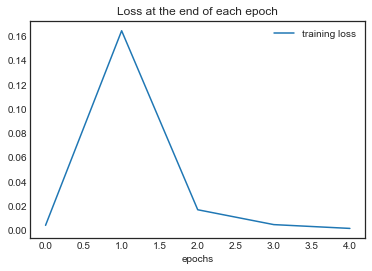

In [18]:
plt.plot(train_losses, label='training loss')
plt.title('Loss at the end of each epoch')
plt.xlabel('epochs')
plt.legend();

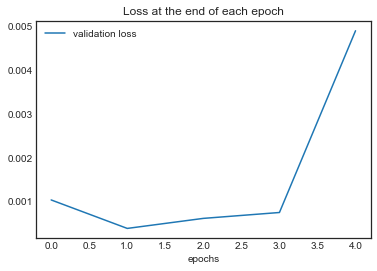

In [19]:
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.xlabel('epochs')
plt.legend();

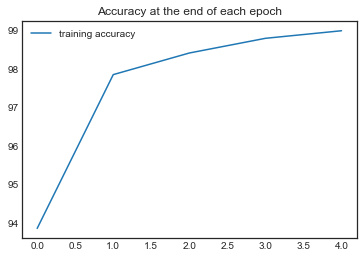

In [20]:
plt.plot([t/600 for t in train_correct], label='training accuracy')

plt.title('Accuracy at the end of each epoch')
plt.legend();

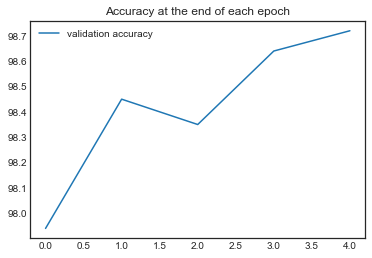

In [21]:
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

### Overall Evaluation

In [22]:
test_load = DataLoader(test_data,batch_size=10000, shuffle=False)

In [23]:
with torch.no_grad():
    correct = 0
    for x_test, y_test in test_load:
        y_val = net(x_test)
        _, predicted = y_val.max(1)
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9872/10000 =  98.720%


In [24]:
predicted

tensor([7, 2, 1,  ..., 4, 5, 6])

In [25]:
# Missed Pictures and their indexes
misses = np.array([])

for i in range(len(predicted.view(-1))):
    
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
    
misses

array([  18,   62,  115,  158,  340,  359,  551,  582,  619,  629,  659,
        684,  716,  720,  740,  924,  947, 1014, 1039, 1112, 1226, 1242,
       1247, 1299, 1328, 1393, 1500, 1522, 1621, 1709, 1721, 1737, 1782,
       1790, 1878, 1901, 1909, 2018, 2024, 2035, 2070, 2090, 2130, 2135,
       2293, 2343, 2447, 2488, 2496, 2582, 2597, 2648, 2654, 2743, 2771,
       2927, 2939, 2953, 2959, 2970, 3030, 3225, 3289, 3448, 3520, 3702,
       3726, 3756, 3762, 3767, 3778, 3806, 3808, 3902, 3906, 3941, 4163,
       4176, 4194, 4201, 4284, 4360, 4497, 4504, 4536, 4571, 4740, 4783,
       4838, 4860, 4880, 4911, 5127, 5457, 5634, 5642, 5937, 5955, 5973,
       5981, 5997, 6101, 6560, 6571, 6576, 6597, 6625, 6651, 6783, 6883,
       7216, 7574, 7899, 7928, 7990, 8279, 8325, 8469, 8509, 8520, 9009,
       9540, 9669, 9729, 9839, 9891, 9904, 9905])

### Single Image Test

Text(0.5, 1.0, 'Label 3')

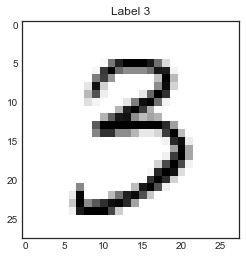

In [26]:
index = 2020
plt.figure(figsize=(4,4))
plt.imshow(x_test[index].reshape(28,28),cmap='binary')
plt.title('Label {}'.format(y_test[2020]))

In [27]:
net.eval()
with torch.no_grad():
    yhat = net(x_test[index][0].view(1,1,28,28))
    print('Prediction ~ {}'.format(yhat.argmax()))
    print('Reality - {}'.format(y_test[index]))

Prediction ~ 3
Reality - 3


### Miscellaneous

In [28]:
# PipeLine Script Data  

In [89]:
project_name = 'MNIST'
framework = 'Pytorch'
prediction_type = 'Classification'
network_type = 'Convolutional Neural Network'
Architecture = str(net)
layers = 6
hidden_units = None 
Activations = "['relu','softmax']"
epochs = 5
metrics = 'Accuracy'
Train_Accuracy = np.mean(accuracy)
Test_Accuracy = 98.720
elapsed = '2.48 Min'
Desc = desc.strip()


In [90]:
param = dict()
var = ['project_name', 'framework','prediction_type','network_type',
       'Architecture','layers','hidden_units','Activations','epochs',
       'metrics','Train_Accuracy','Test_Accuracy','elapsed','Desc']

In [91]:
for val in var:
    param[val] = eval(val)

In [92]:
import pickle
file = open("state_dict.txt", "wb") 
  
dictionary = param 
  
pickle.dump(dictionary, file) 
file.close() 


In [95]:
param

{'project_name': 'MNIST',
 'framework': 'Pytorch',
 'prediction_type': 'Classification',
 'network_type': 'Convolutional Neural Network',
 'Architecture': 'convolutional(\n  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))\n  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)\n  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))\n  (fc1): Linear(in_features=400, out_features=120, bias=True)\n  (fc2): Linear(in_features=120, out_features=64, bias=True)\n  (fc3): Linear(in_features=64, out_features=10, bias=True)\n)',
 'layers': 6,
 'hidden_units': None,
 'Activations': "['relu','softmax']",
 'epochs': 5,
 'metrics': 'Accuracy',
 'Train_Accuracy': 96.62335542328043,
 'Test_Accuracy': 98.72,
 'elapsed': '2.48 Min',
 'Desc': 'The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have b

In [99]:
import pandas as pd
pd.DataFrame(pd.Series(param)).T

,project_name,framework,prediction_type,network_type,Architecture,layers,hidden_units,Activations,epochs,metrics,Train_Accuracy,Test_Accuracy,elapsed,Desc
0,MNIST,Pytorch,Classification,Convolutional Neural Network,"convolutional(\n (conv1): Conv2d(1, 6, kernel...",6,None,"['relu','softmax']",5,Accuracy,96.6234,98.72,2.48 Min,"The MNIST database of handwritten digits, avai..."
